In [1]:
import YXJ
import torch
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import numpy as np
import torch.nn.functional as F

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np

class TimeSeriesDataset(Dataset):
    def __init__(self, csv_file, steps_per_sample):
        self.data_frame = pd.read_csv(csv_file) # 读取CSV文件
        self.steps_per_sample = steps_per_sample
        # 预处理数据
        n_samples = len(self.data_frame) // steps_per_sample
        self.data_frame = self.data_frame.iloc[:n_samples * steps_per_sample]
        self.data_frame = self.data_frame.values.reshape(n_samples, steps_per_sample,-1)
        
    def __len__(self):
        return len(self.data_frame)
    
    def __getitem__(self, idx):
        sample = self.data_frame[idx]
        X = sample[:, :-1]  # 所有行，除了最后一列
        y = sample[0, -1]   # 第一个时间步的标签
        
        # 转换为Tensor
        X = torch.tensor(X, dtype=torch.float32)
        X = X.transpose(0, 1)
        y = torch.tensor(y, dtype=torch.long)
        return X, y


# 使用示例
SAMPLES_PER_GESTURE = 100
dataset = TimeSeriesDataset('normalized_data.csv', SAMPLES_PER_GESTURE)
GESTURES = ["smoke", "nosmoke"]  # 手势列表
NUM_GESTURES= len(GESTURES);

# 分割数据集
from torch.utils.data import random_split
dataset_size = len(dataset)
train_size = int(dataset_size * 0.7)  # 70% 数据用于训练
valid_size = int(dataset_size * 0.2)  # 20% 数据用于验证
test_size = dataset_size - train_size - valid_size  # 剩余10% 用于测试
batch_size =64;
train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size, test_size])
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

YXJ.check_dataloader(test_loader)
input_size=SAMPLES_PER_GESTURE*9

torch.Size([64, 9, 100]) tensor([1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1])
torch.Size([64, 9, 100]) tensor([1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1,
        0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0])
torch.Size([64, 9, 100]) tensor([0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0,
        1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0,
        0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1])
torch.Size([64, 9, 100]) tensor([1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
        0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1,
        0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1])
torch.Size([64, 9, 100]) tensor(

In [3]:
import torch
import torch.nn as nn

# 定义模型
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

In [4]:
def validate(model, device, criterion, test_loader):
    model.eval()
    validation_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            validation_loss += criterion(output, target).item()
    validation_loss /= len(test_loader)  # 计算平均验证损失
    return validation_loss
    
def train(model, device, train_loader, criterion, optimizer, epochs):
    model.train()
    train_losses = []  # 用于存储每个epoch的损失值
    for epoch in range(epochs):
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()           # 清零梯度
            output = model(data)            # 前向传播
            loss = criterion(output, target) # 计算损失
            loss.backward()                 # 反向传播
            optimizer.step()                # 更新参数
        train_losses.append(loss.item())
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')
    return train_losses
    
def train_vali(model, device, train_loader, test_loader, criterion, optimizer, epochs):
    model.train()
    train_losses = []
    validation_losses = []
    for epoch in range(epochs):
        model.train()
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()  # 清零梯度
            output = model(data)  # 前向传播
            loss = criterion(output, target)  # 计算损失
            loss.backward()  # 反向传播
            optimizer.step()  # 更新参数
        train_losses.append(loss.item())
        
        # 在每个epoch后计算验证集上的损失
        validation_loss = validate(model, device, criterion, test_loader)
        validation_losses.append(validation_loss)
        
        print(f'Epoch {epoch+1}, Training Loss: {loss.item()}, Validation Loss: {validation_loss}')

    return train_losses, validation_losses
    
def test(model, device, test_loader):
    model.eval()  # 将模型设置为评估模式
    test_loss = 0
    correct = 0  # 用于累计正确预测的数量
    with torch.no_grad():  # 在评估阶段不计算梯度
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # 累加损失值
            pred = output.argmax(dim=1, keepdim=True)  # 找到概率最高的类别作为预测
            correct += pred.eq(target.view_as(pred)).sum().item()  # 如果预测正确，则累加到correct变量中

    test_loss /= len(test_loader.dataset)  # 计算平均损失
    accuracy = 100. * correct / len(test_loader.dataset)  # 计算准确率

    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.4f}%)')
    print(len(test_loader.dataset))

Epoch 1, Training Loss: 0.6910911798477173, Validation Loss: 0.6861624734269248
Epoch 2, Training Loss: 0.40190404653549194, Validation Loss: 0.4144453778862953
Epoch 3, Training Loss: 0.24479667842388153, Validation Loss: 0.1856297082785103
Epoch 4, Training Loss: 0.16757172346115112, Validation Loss: 0.15199073321289486
Epoch 5, Training Loss: 0.08095979690551758, Validation Loss: 0.16038455565770468
Epoch 6, Training Loss: 0.09520608931779861, Validation Loss: 0.13806047187083298
Epoch 7, Training Loss: 0.23196229338645935, Validation Loss: 0.1420481459548076
Epoch 8, Training Loss: 0.11880331486463547, Validation Loss: 0.11904031907518704
Epoch 9, Training Loss: 0.08981801569461823, Validation Loss: 0.10858527871055736
Epoch 10, Training Loss: 0.17522817850112915, Validation Loss: 0.10243784894959794
Epoch 11, Training Loss: 0.12137782573699951, Validation Loss: 0.10139717368615998
Epoch 12, Training Loss: 0.05601617321372032, Validation Loss: 0.07166625564504
Epoch 13, Training Lo

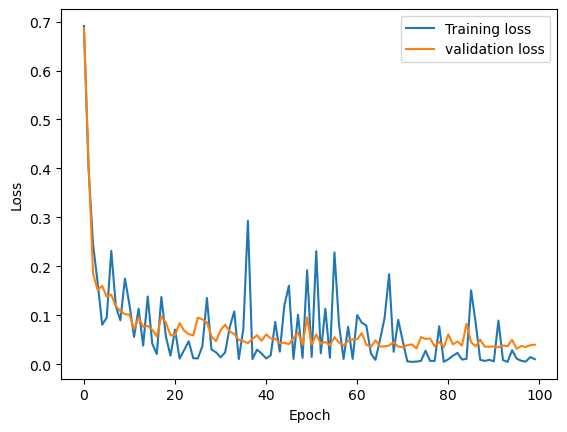


Test set: Average loss: 0.0401, Accuracy: 2275/2300 (98.9130%)
2300

Test set: Average loss: 0.0342, Accuracy: 1144/1152 (99.3056%)
1152


In [7]:
# 使用GPU
use_cuda = torch.cuda.is_available()
device=torch.device('cuda' if use_cuda else 'cpu')
hidden_size =30
layers_num =30
model = RNNModel(100, hidden_size,layers_num,2).to(device) 
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# 假设 train_loader 和 test_loader 已经定义
train_losses, validation_losses=train_vali(model, device, train_loader, valid_loader, criterion, optimizer, epochs=100)
YXJ.draw_loss(train_losses,validation_losses)
test(model, device, valid_loader)
test(model, device, test_loader)

In [6]:
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.4f}%)')
    print(len(test_loader.dataset))

NameError: name 'test_loss' is not defined